#**Libraries Importation and Categorization**

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve,auc,
                            confusion_matrix, classification_report)
from sklearn.pipeline import Pipeline


from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier,
                             IsolationForest)
import xgboost as xgb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

#**Loading the Raw Dataset form Payloads CSV**

In [2]:
df=pd.read_csv('Payloads.csv', encoding='latin-1')
df.head()

,Payloads,Class
0,http://www.nwce.gov.uk/search_process.php?keyw...,Malicious
1,http://www.manchester.gov.uk/site/scripts/goog...,Malicious
2,http://www.ldsmissions.com/us/index.php?action...,Malicious
3,http://education.powys.gov.uk/english/adult_ed...,Malicious
4,http://www.northwarks.gov.uk/site/scripts/goog...,Malicious


# **Basic Exploratory Data Analysis**
**A. Basic Data Summary**


1. Distribution of benign vs. malicious samples.
2. Dataset Statistics Before Cleaning


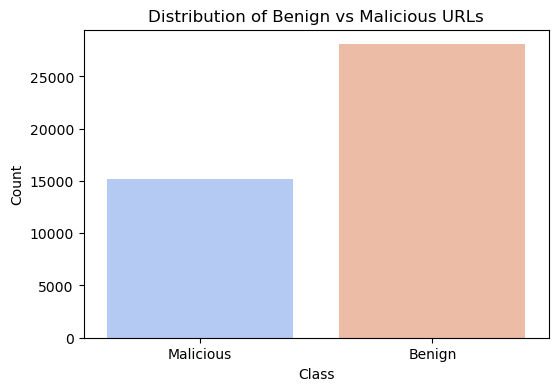

,Payloads,Class
count,43217,43217
unique,42671,2
top,http://www.marksandspencer.com/gp/search/202-6...,Benign
freq,2,28068


In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Class", data=df, palette="coolwarm")
plt.title("Distribution of Benign vs Malicious URLs")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


df.describe()


#**B. Feature Engineering**

1. Creating Different Features from the Url in the Payload
2. Encoding column Class into 0-Benign and 1-Malicious
3. Creating a new clean Dataset and Saving it as CSV file

In [ ]:
def extract_features(payload):
    return {
        'Contains &lt': '&lt' in payload,
        'ScripTag': '<script' in payload.lower(),
         # Checks for non-ASCII chars
        'Readable': not any(ord(c) > 127 for c in payload),
        'Contains "><': '"><' in payload,
        "Contains '><": "'><" in payload,
        'Contains And': '&' in payload,
        'Contains Percentage': '%' in payload,
        'Contains Slash': '/' in payload,
        'Contains BackSlash': '\\' in payload,
        'Contains Plus': '+' in payload,
        'Contains Document': 'document' in payload.lower(),
        'Contains Window': 'window' in payload.lower(),
        'Contains Onload': 'onload' in payload.lower(),
        'Contains Onerror': 'onerror' in payload.lower(),
        'Contains DIV': '<div' in payload.lower(),
        'Contains iframe': '<iframe' in payload.lower(),
        'Contains img': '<img' in payload.lower(),
        'Contains SRC': 'src' in payload.lower(),
        'Containss Var': 'var' in payload.lower(),
        'Contains Eval': 'eval' in payload.lower(),
        'Contains href': 'href' in payload.lower(),
        'Contains Cookie': 'cookie' in payload.lower(),
        'Contains StringfromCharCode': 'fromcharcode' in payload.lower(),
        'Contains Single Quote': "'" in payload,
        'Contains Question Mark': '?' in payload,
        'Contains Exclamation Mark': '!' in payload,
        'Contains Semicolon': ';' in payload,
        'Contains HTTP': 'http' in payload.lower(),
        'Contains JS': 'javascript' in payload.lower(),
        'Contains Hash': '#' in payload,
        'Contains Equal': '=' in payload,
        'Contains Open Bracket': '[' in payload,
        'Contains Close Bracket': ']' in payload,
        'Contains Duble Bracket': '[]' in payload,
        'Contains Dollar': '$' in payload,
        'Contains Open Parenthesis': '(' in payload,
        'Contains Close Parenthesis': ')' in payload,
        'Contains Asterisk': '*' in payload,
        'Contains Comma': ',' in payload,
        'Contains Hyphen': '-' in payload,
        'Contains Less Than': '<' in payload,
        'Contains Greater Than': '>' in payload,
        'Contains At': '@' in payload,
        'Contains Underscore': '_' in payload,
        'Contains location': 'location' in payload.lower(),
        'Contains Search': 'search' in payload.lower(),
        'Contains &#': '&#' in payload,
        'Contains Colon': ':' in payload,
        'Contains Dots': '..' in payload,
        'Contains Open Brace': '{' in payload,
        'Contains Close Brace': '}' in payload,
        'Contains tilde': '~' in payload,
        # Checks if payload contains a space
        'Contains Spase': ' ' in payload,
        # Checks for double quotes
        'Contains Qutions': '"' in payload,
        'Contains Grave': '`' in payload,
        'Contains Duble Equals': '==' in payload,
        'Contains Duble Slash': '//' in payload,
        'Contains Vertical Bar': '|' in payload,
        'Contains Power': '^' in payload,
        'Contains Broken Bar': '¦' in payload,
        'Contains Alert': 'alert' in payload.lower(),
         # Checks for newlines
        'Contains Break Line': '\n' in payload,

        # Ratio Features
        'Letters Ratio': sum(c.isalpha() for c in payload) / len(payload) if payload else 0,
        'Numbuers Ratio': sum(c.isdigit() for c in payload) / len(payload) if payload else 0,
        'Symbols Ratio': sum(not c.isalnum() for c in payload) / len(payload) if payload else 0
    }

features_df = df["Payloads"].apply(extract_features).apply(pd.Series)

df["Class"] = df["Class"].map({"Malicious": 1, "Benign": 0})

df_final = pd.concat([features_df, df["Class"]], axis=1)

df_final.to_csv("processed_xss_dataset.csv", index=False)

print("Dataset preprocessing completed!")

Dataset preprocessing completed!


#**C. Data Cleaning and Preprocessing**
1. Load the  new proprocessed Dataset
2. Check and Remove duplicates values
3. Check and Fill or deop the missing values
4. Save the New Cleaned Dataset
5. Ensure all columns have the correct data types

In [5]:
df = pd.read_csv("processed_xss_dataset.csv")

duplicates = df.duplicated().sum()
print(f"Duplicates Found: {duplicates}")

df = df.drop_duplicates()

missing_values = df.isnull().sum()
print("Missing Values per Column:\n", missing_values[missing_values > 0])

df = df.dropna()

df = df.astype({col: 'int' for col in df.columns if col != 'Letters Ratio' and col != 'Numbuers Ratio' and col != 'Symbols Ratio'})
df[["Letters Ratio", "Numbuers Ratio", "Symbols Ratio"]] = df[["Letters Ratio", "Numbuers Ratio", "Symbols Ratio"]].astype(float)

df.to_csv("cleaned_xss_dataset.csv", index=False)

print("Data Cleaning Completed!.")

Duplicates Found: 14877
Missing Values per Column:
 Series([], dtype: int64)
Data Cleaning Completed!.


In [6]:
df = pd.read_csv("cleaned_xss_dataset.csv")
print("Dataset shape:", df.shape)
print("\nFirst 3 rows:")
df.head(3)

Dataset shape: (28340, 66)

First 3 rows:


,Contains &lt,ScripTag,Readable,"Contains ""><",Contains '><,Contains And,Contains Percentage,Contains Slash,Contains BackSlash,Contains Plus,...,Contains Duble Slash,Contains Vertical Bar,Contains Power,Contains Broken Bar,Contains Alert,Contains Break Line,Letters Ratio,Numbuers Ratio,Symbols Ratio,Class
0,0,0,1,0,0,0,1,1,0,0,...,1,0,0,0,1,0,0.681034,0.112069,0.206897,1
1,0,0,1,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0.695067,0.080717,0.224215,1
2,0,0,1,0,0,1,1,1,0,0,...,1,0,0,0,0,0,0.764706,0.050420,0.184874,1


In [7]:
binary_features = [col for col in df.columns if col not in ["Letters Ratio", "Numbuers Ratio", "Symbols Ratio", "Class"]]
binary_summary = df[binary_features].sum().sort_values(ascending=False)

print("Top 20 most frequent malicious indicators:")
binary_summary.head(20)

Top 20 most frequent malicious indicators:


Readable                      27649
Contains Equal                19052
Contains Slash                19041
Contains Colon                18185
Contains Duble Slash          16403
Contains HTTP                 15967
Contains Question Mark        14773
Contains And                  14274
Contains Open Parenthesis     13800
Contains Close Parenthesis    13785
Contains Percentage           11761
Contains Spase                11482
Contains Hyphen               11453
Contains Semicolon            11049
Contains Alert                 9721
Contains Comma                 9443
Contains Greater Than          9358
Contains Less Than             9357
Contains Single Quote          8455
Contains Plus                  6138
dtype: int64

In [ ]:
to_drop = [
     # Almost always 1 (non-discriminative)
    "Readable",
     # Almost always 1 (non-discriminative)
    "Contains Equal",
     # Too common (e.g., "=" in benign queries)
    "Contains Slash",
     # Too common (e.g., "http://")
    "Contains Colon",
     # Too common (e.g., "https:")
    "Contains Duble Slash",
     # Redundant with "Contains Slash"
    "Contains HTTP",
     # Too common (all URLs have "http")
    "Contains Spase",
     # Typo? Also, spaces are rare in URLs
    "Contains Hyphen",
     # Common in benign URLs (e.g., "example-com")
    "Contains Comma",
     # Low predictive power
    "Contains Plus",
     # Rarely indicates XSS
]
df_filtered = df.drop(columns=to_drop)
print("Remaining features:", df_filtered.shape[1])

Remaining features: 56


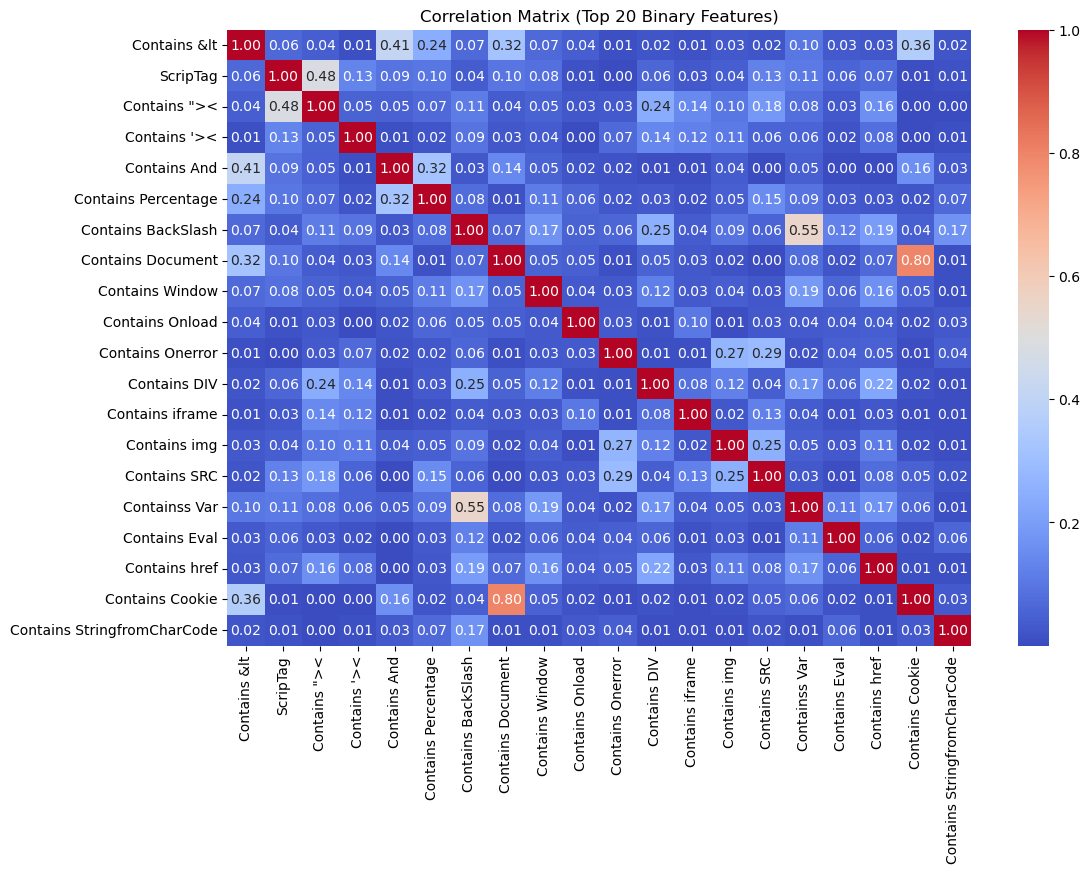

In [9]:
binary_features_filtered = [col for col in df_filtered.columns
                          if col not in ["Letters Ratio", "Numbuers Ratio", "Symbols Ratio", "Class"]]
corr_matrix = df_filtered[binary_features_filtered].corr().abs()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.iloc[:20, :20], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Top 20 Binary Features)")
plt.show()

In [ ]:
binary_features = [col for col in df_filtered.columns
                  if col not in ["Letters Ratio", "Numbuers Ratio", "Symbols Ratio", "Class"]]
corr_matrix = df_filtered[binary_features].corr().abs()

high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.5:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

high_corr_df = pd.DataFrame(high_corr, columns=["Feature A", "Feature B", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", ascending=False)

print("Highly Correlated Feature Pairs (Correlation > 0.5):")
print(high_corr_df.to_string(index=False))

Highly Correlated Feature Pairs (Correlation > 0.5):
                 Feature A                 Feature B  Correlation
Contains Close Parenthesis Contains Open Parenthesis     0.993433
    Contains Close Bracket     Contains Open Bracket     0.991948
     Contains Greater Than        Contains Less Than     0.979339
      Contains Close Brace       Contains Open Brace     0.951039
           Contains Cookie         Contains Document     0.797068
       Contains Open Brace        Contains BackSlash     0.755838
      Contains Close Brace        Contains BackSlash     0.723883
       Contains Open Brace    Contains Close Bracket     0.694819
       Contains Open Brace     Contains Open Bracket     0.692187
      Contains Close Brace    Contains Close Bracket     0.666804
      Contains Close Brace     Contains Open Bracket     0.663517
     Contains Duble Equals       Contains Open Brace     0.653991
    Contains Duble Bracket    Contains Close Bracket     0.644793
    Contains Duble Brac

In [11]:
to_drop_corr = [
    # Parenthesis/Brackets/Braces groups (keep only one per pair)
     # Keep Close Parenthesis (nearly identical)
    "Contains Open Parenthesis",
     # Keep Close Bracket
    "Contains Open Bracket",
    # Keep Close Brace
    "Contains Open Brace",
   # Keep Greater Than (more relevant to XSS)
    "Contains Less Than",

    # Other redundant features
    "Contains Document",          # Keep Cookie (more XSS-specific)
    "Contains BackSlash",         # Covered by bracket/brace features
    "Contains Duble Bracket",     # Redundant with single brackets
    "Contains Duble Equals",      # Rarely meaningful for XSS
    "Contains Qutions"            # Typo? Also covered by quote features
]

df_final = df_filtered.drop(columns=to_drop_corr)
print(f"Final feature count: {df_final.shape[1]}")

Final feature count: 47


In [12]:
# Train a quick model
X_final = df_final.drop(columns=["Class"])
y_final = df_final["Class"]
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_final, y_final)

# Get top features
importances = pd.Series(rf.feature_importances_, index=X_final.columns)
print("Top 15 features after pruning:\n", importances.sort_values(ascending=False).head(15))

Top 15 features after pruning:
 Contains Alert                0.240048
Contains Semicolon            0.102870
Contains Question Mark        0.100681
Contains Greater Than         0.099709
Symbols Ratio                 0.072945
Letters Ratio                 0.052559
Numbuers Ratio                0.043568
Contains &lt                  0.040457
Contains And                  0.034132
Contains Percentage           0.024742
Contains Search               0.022257
Contains Close Parenthesis    0.018752
Contains SRC                  0.018642
Contains Single Quote         0.016286
Contains Close Brace          0.016082
dtype: float64


In [13]:
important_features = importances[importances >= 0.01].index.tolist()
df_optimized = df_final[important_features + ["Class"]]
print(f"Optimized features: {len(important_features)}")
print("Dropped features:", set(df_final.columns) - set(important_features + ["Class"]))

Optimized features: 18
Dropped features: {'Contains At', 'Contains img', 'Contains Asterisk', 'Contains "><', 'Contains Onerror', 'Contains Grave', "Contains '><", 'Contains tilde', 'Contains Underscore', 'Contains DIV', 'Contains Break Line', 'Contains Close Bracket', 'Contains Dollar', 'Contains href', 'Contains Dots', 'Contains &#', 'ScripTag', 'Contains Hash', 'Contains Vertical Bar', 'Contains Onload', 'Contains StringfromCharCode', 'Contains location', 'Contains Broken Bar', 'Contains Window', 'Contains iframe', 'Contains Power', 'Contains Eval', 'Contains JS'}


In [14]:
print("Optimized Features:\n", important_features)

Optimized Features:
 ['Contains &lt', 'Contains And', 'Contains Percentage', 'Contains SRC', 'Containss Var', 'Contains Cookie', 'Contains Single Quote', 'Contains Question Mark', 'Contains Exclamation Mark', 'Contains Semicolon', 'Contains Close Parenthesis', 'Contains Greater Than', 'Contains Search', 'Contains Close Brace', 'Contains Alert', 'Letters Ratio', 'Numbuers Ratio', 'Symbols Ratio']


In [15]:
df_optimized.to_csv("xss_optimized_dataset.csv", index=False)
print("Optimized dataset saved with shape:", df_optimized.shape)

Optimized dataset saved with shape: (28340, 19)


#**Advanced Exploratory Data Analysis (EDA)**
**A. Histogram**
1. Plotting a  Histogram to show distribution of the data across various features(Letters Ratio, Numbers Ration, and Symbols Ratio)

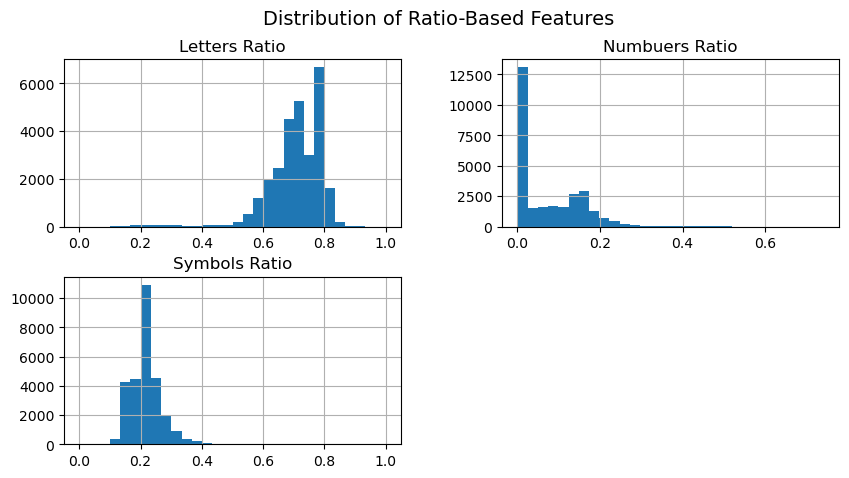

In [16]:
ratio_features = ["Letters Ratio", "Numbuers Ratio", "Symbols Ratio"]

colors = ['blue', 'green', 'red']

df[ratio_features].hist(figsize=(10, 5), bins=30)

for i, feature in enumerate(ratio_features):
    plt.gca().get_children()[i].set_color(colors[i])

plt.suptitle("Distribution of Ratio-Based Features", fontsize=14)
plt.show()



**B. Boxplot**

To show variability among the Key Features

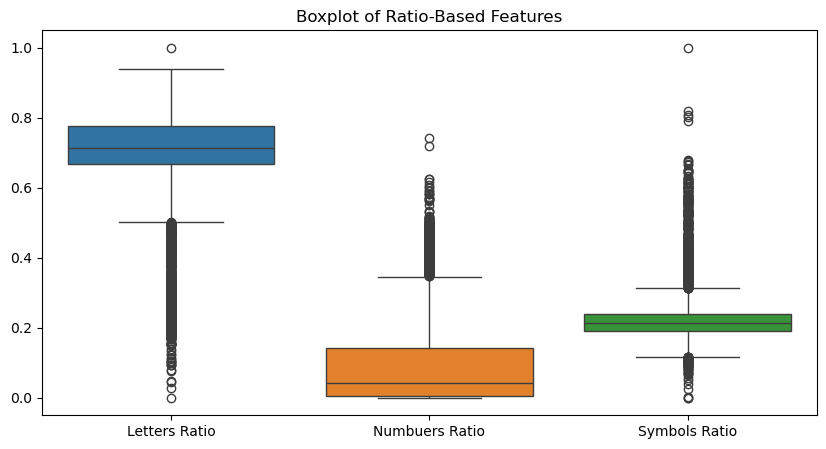

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_optimized[ratio_features])
plt.title("Boxplot of Ratio-Based Features")
plt.show()

**C. Countplots**

To visualize the frequency distribution of categorical features.

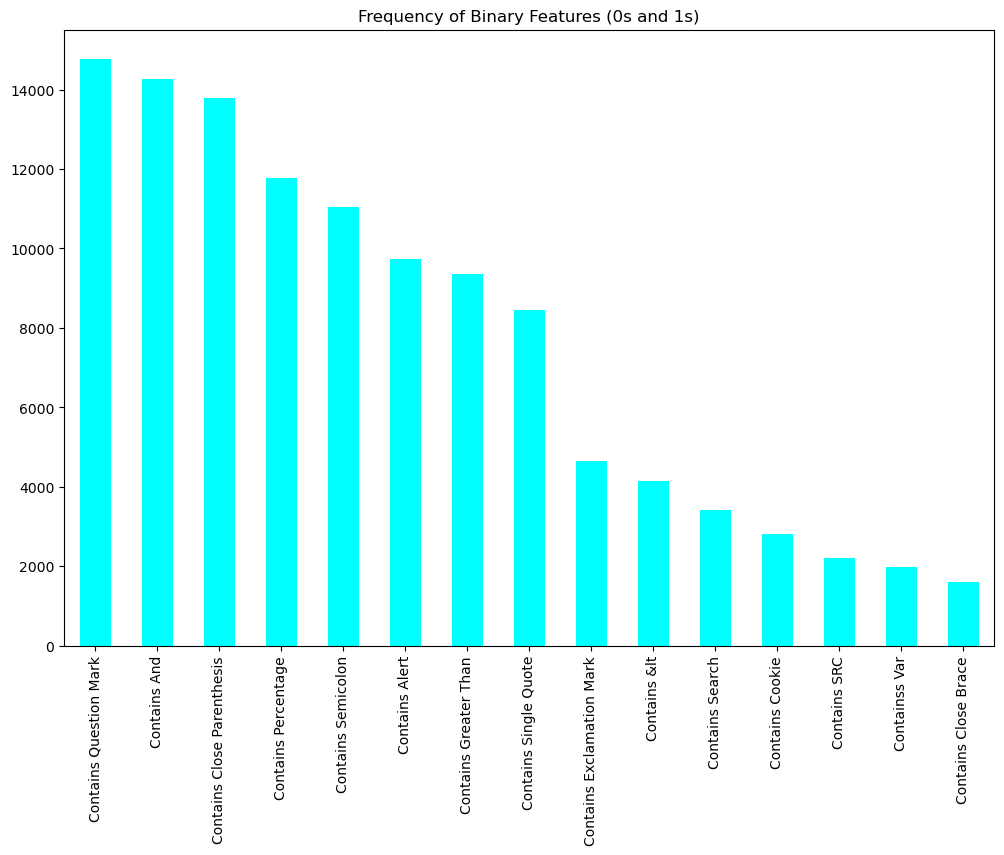

In [18]:
binary_features = df_optimized.drop(columns=["Letters Ratio", "Numbuers Ratio", "Symbols Ratio", "Class"]).columns

plt.figure(figsize=(12, 8))
df[binary_features].sum().sort_values(ascending=False).plot(kind="bar", color="cyan")
plt.title("Frequency of Binary Features (0s and 1s)")
plt.xticks(rotation=90)
plt.show()

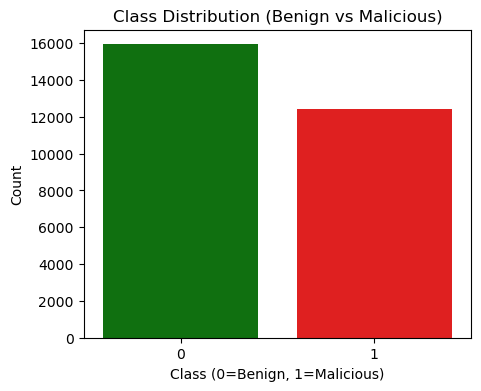

In [19]:
plt.figure(figsize=(5, 4))
sns.countplot(x=df_optimized["Class"], palette=["green", "red"])
plt.title("Class Distribution (Benign vs Malicious)")
plt.xlabel("Class (0=Benign, 1=Malicious)")
plt.ylabel("Count")
plt.show()

In [ ]:
df = pd.read_csv("xss_optimized_dataset.csv")

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["Class"])

train_df.to_csv("train_xss_dataset.csv", index=False)

test_df.to_csv("test_xss_dataset.csv", index=False)

print("Dataset split completed!")
print(f"Training set size: {train_df.shape}")
print(f"Testing set size: {test_df.shape}")

Dataset split completed!
Training set size: (19838, 19)
Testing set size: (8502, 19)


In [ ]:
train_df = pd.read_csv("train_xss_dataset.csv")

X_train = train_df.drop(columns=["Class"])

iso_forest = IsolationForest(contamination=0.05, random_state=42)

outlier_predictions = iso_forest.fit_predict(X_train)

train_df["Outlier"] = outlier_predictions

outlier_count = (train_df["Outlier"] == -1).sum()
print(f"Outliers Detected: {outlier_count}")

Outliers Detected: 992


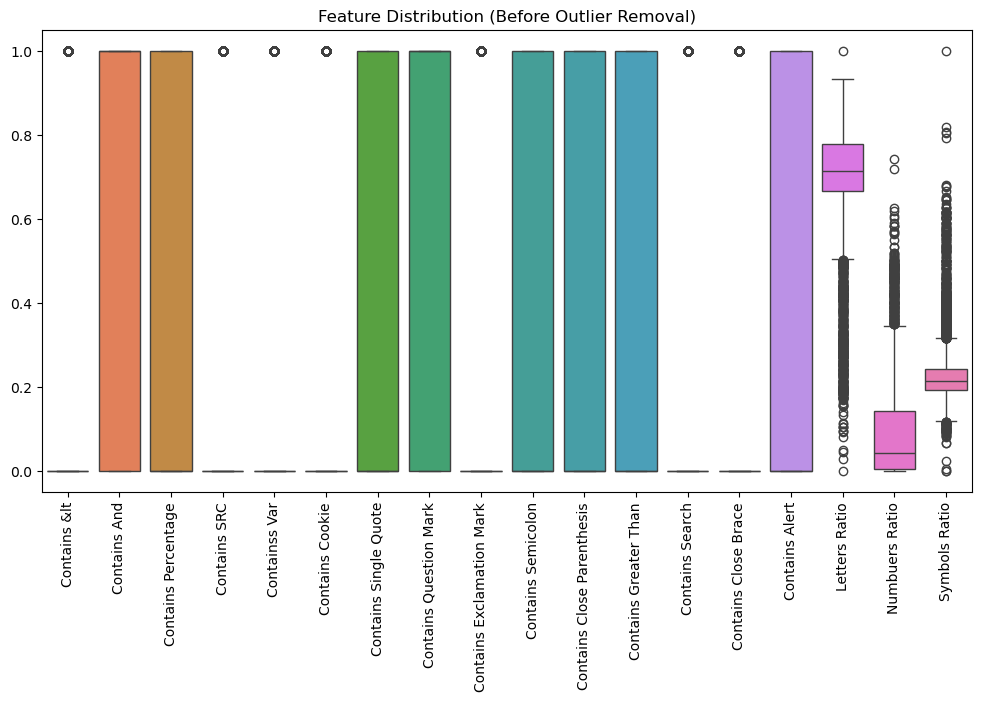

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train)
plt.xticks(rotation=90)
plt.title("Feature Distribution (Before Outlier Removal)")
plt.show()

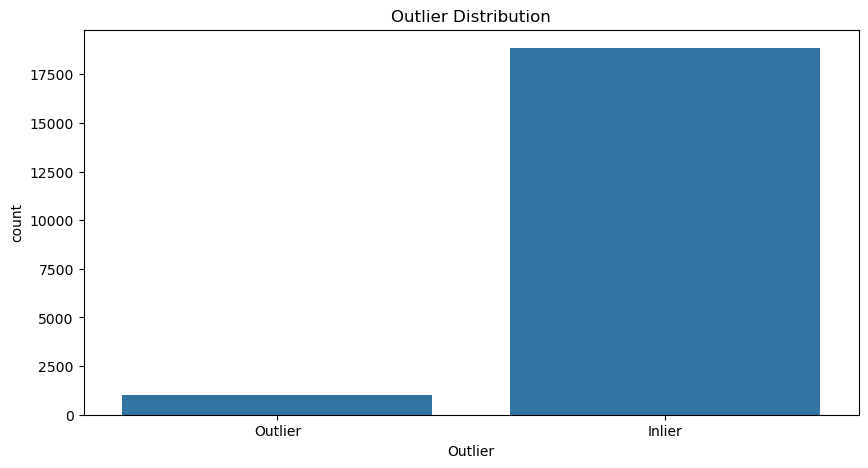

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x=train_df["Outlier"])
plt.title("Outlier Distribution")
plt.xticks([0, 1], ["Outlier", "Inlier"])
plt.show()

In [24]:
clean_train_df = train_df[train_df["Outlier"] == 1].drop(columns=["Outlier"])

clean_train_df.to_csv("train_xss_dataset_cleaned.csv", index=False)

print(f"Outliers removed! New dataset size: {clean_train_df.shape}")

Outliers removed! New dataset size: (18846, 19)


#**Model Developments**

**A.Support Vector Machines SVM**

1. Loading the training and testing  datasets.
2. Separate features and labels(Benign, Malicious).
3. Standardize the numerical features ( to  ensure all features are on similar scale).
4. Training the SVM model.
5. Evaluating the performance of the SVM using :F1-Score, Recall, Precision,  Accuracy, AUC-ROC Score.
6.Plotting the AUC_ROC curve for SVM.

Fitting 3 folds for each of 5 candidates, totalling 15 fits

Train Performance: {'Accuracy': 0.9936326010824578, 'Precision': 0.996555541887071, 'Recall': 0.9887709019895032, 'F1 Score': 0.9926479598088469, 'AUC-ROC': 0.9996269421496182}
Test Performance: {'Accuracy': 0.9807104210773936, 'Precision': 0.970386039132734, 'Recall': 0.9860290166577109, 'F1 Score': 0.9781449893390192, 'AUC-ROC': 0.997245204921995}

Performance Gap (Train - Test):
Accuracy: 0.0129
Precision: 0.0262
Recall: 0.0027
F1 Score: 0.0145
AUC-ROC: 0.0024


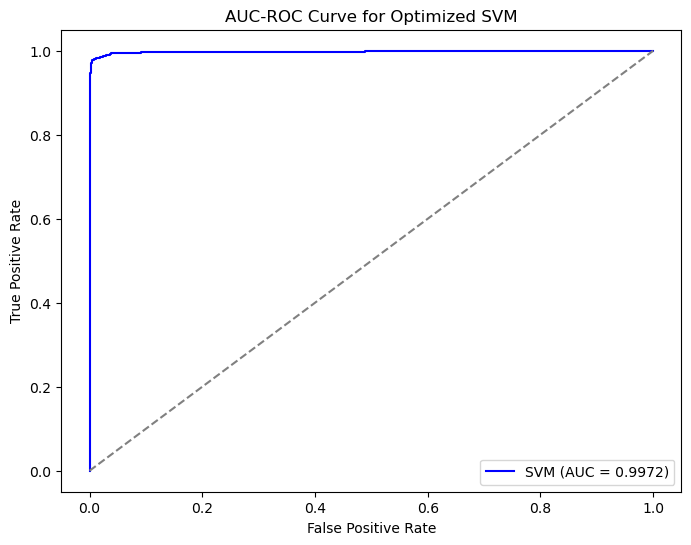

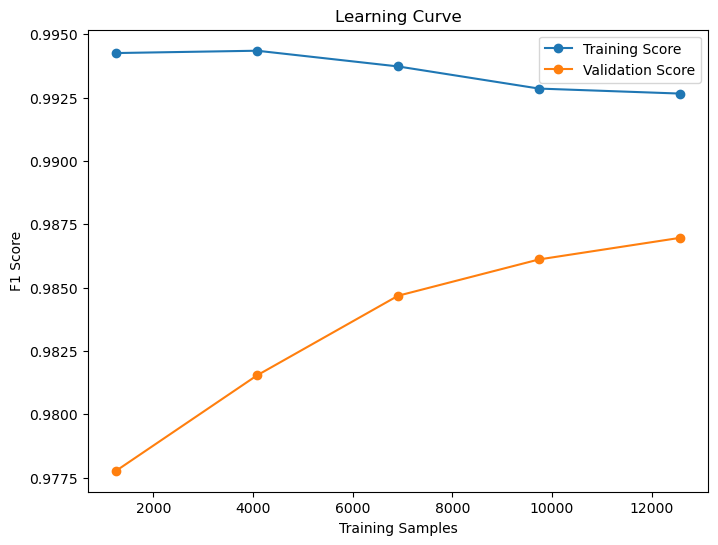

In [25]:
train_df = pd.read_csv("train_xss_dataset_cleaned.csv")
test_df = pd.read_csv("test_xss_dataset.csv")

X_train, y_train = train_df.drop(columns=["Class"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel="rbf", probability=True, random_state=42))
])

param_dist = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.1]
}

random_search = RandomizedSearchCV(
    pipeline, param_dist, n_iter=5, cv=3, scoring='f1', verbose=1, n_jobs=1, random_state=42
)
random_search.fit(X_train, y_train)

best_svm = random_search.best_estimator_

y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

y_train_pred_proba = best_svm.predict_proba(X_train)[:, 1]
y_test_pred_proba = best_svm.predict_proba(X_test)[:, 1]

train_metrics = {
    "Accuracy": accuracy_score(y_train, y_train_pred),
    "Precision": precision_score(y_train, y_train_pred),
    "Recall": recall_score(y_train, y_train_pred),
    "F1 Score": f1_score(y_train, y_train_pred),
    "AUC-ROC": roc_auc_score(y_train, y_train_pred_proba)
}

test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred),
    "AUC-ROC": roc_auc_score(y_test, y_test_pred_proba)
}

print("\nTrain Performance:", train_metrics)
print("Test Performance:", test_metrics)

print("\nPerformance Gap (Train - Test):")
for metric in train_metrics.keys():
    print(f"{metric}: {train_metrics[metric] - test_metrics[metric]:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"SVM (AUC = {test_metrics['AUC-ROC']:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Optimized SVM")
plt.legend()
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    best_svm, X_train, y_train, cv=3, scoring="f1", train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validation Score")
plt.xlabel("Training Samples")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [26]:
sample_indices = X_test.sample(5, random_state=42).index
X_sample = X_test.loc[sample_indices]
y_sample_actual = y_test.loc[sample_indices]

y_sample_pred = best_svm.predict(X_sample)
y_sample_proba = best_svm.predict_proba(X_sample)[:, 1]  

results_df = pd.DataFrame({
    "Actual Label": y_sample_actual.values,
    "Predicted Label": y_sample_pred,
    "Prediction Confidence": y_sample_proba
}, index=sample_indices)

print("Model Predictions on Sample Test Cases:")
print(results_df)

Model Predictions on Sample Test Cases:
      Actual Label  Predicted Label  Prediction Confidence
457              1                1               0.939694
7997             0                0               0.008616
3346             1                1               0.999999
7621             1                1               0.993853
736              0                0               0.014736


**B.Random Forest RF**

1. Training the RF model.
3. Evaluating the performance of the RF using : F1-Score, Recall, Precision,  Accuracy, AUC-ROC Score.
3. Plotting the AUC_ROC curve for RF.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Random Forest Model Performance:
Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Accuracy: 0.9888
Precision: 0.9858
Recall: 0.9887
F1 Score: 0.9873
AUC-ROC Score: 0.9991


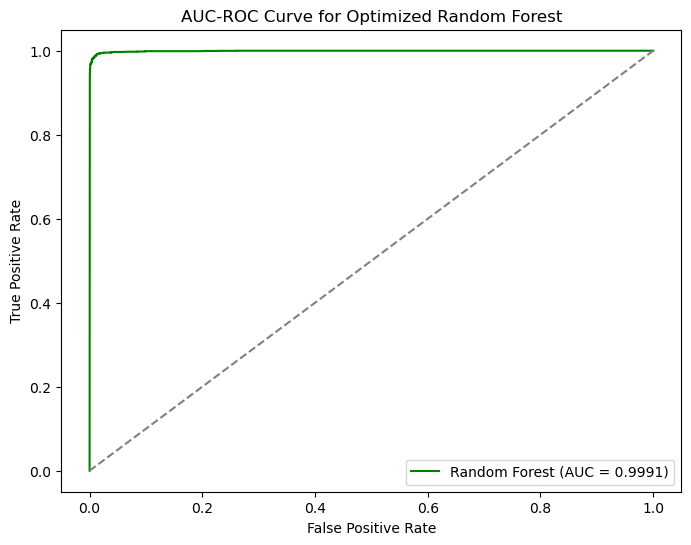

In [27]:
train_df = pd.read_csv("train_xss_dataset_cleaned.csv")
test_df = pd.read_csv("test_xss_dataset.csv")

X_train, y_train = train_df.drop(columns=["Class"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]

rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")

param_dist = {
    "n_estimators": [100, 300, 500],
    # More trees for stability
    "max_depth": [10, 20, 30, None],
    # Allow deep trees
    "min_samples_split": [2, 5, 10],
    # Control overfitting
    "min_samples_leaf": [1, 2, 4],
    # Regularization
    "max_features": ["sqrt", "log2", None],
    # Feature selection
    "bootstrap": [True, False],
    # Bootstrap sampling
}

random_search = RandomizedSearchCV(
    rf_model, param_dist, n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Optimized Random Forest Model Performance:")
print(f"Best Params: {random_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f"Random Forest (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Optimized Random Forest")
plt.legend()
plt.show()

**C. XGBoost XGB**

1. Training the XGB model.
3. Evaluating the performance of the XGB using : F1-Score, Recall, Precision,  Accuracy, AUC-ROC Score.
3. Plotting the AUC_ROC curve for XGB.

XGBoost Model Performance:
Accuracy: 0.9871
Precision: 0.9834
Recall: 0.9871
F1 Score: 0.9853
AUC-ROC Score: 0.9988


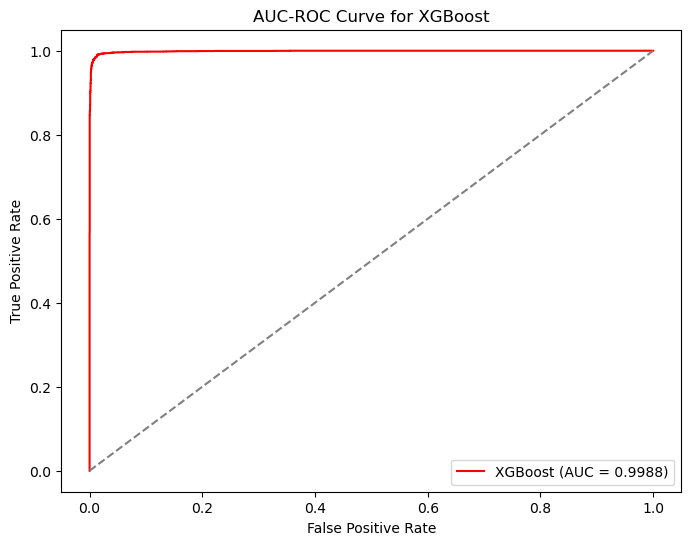

In [28]:
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"XGBoost Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f"XGBoost (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for XGBoost")
plt.legend()
plt.show()


**D. Deep Learning Model DNN**

1. Converting the features to  pytorch tensors.
2. Creating Dataloaders  with batch size of 64 , and data shuffling for train, and testing.
1. Training the DNN using 20 epochs for  model.
3. Evaluating the performance of the DNN using : F1-Score, Recall, Precision,  Accuracy, AUC-ROC Score.
3. Plotting the AUC_ROC curve for DNN.

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

batch_size = 64
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class XSSNet(nn.Module):
    def __init__(self, input_dim):
        super(XSSNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Normalization
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

input_dim = X_train.shape[1]
model = XSSNet(input_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

epochs = 50
patience = 5
best_loss = np.inf
counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Reduce LR if loss plateaus
    scheduler.step(avg_loss)

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break


model.eval()
y_pred_list, y_proba_list = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pred = (outputs >= 0.5).float()
        y_pred_list.extend(y_pred.cpu().numpy().flatten())
        y_proba_list.extend(outputs.cpu().numpy().flatten())

y_pred_list = np.array(y_pred_list)
y_proba_list = np.array(y_proba_list)

accuracy = accuracy_score(y_test, y_pred_list)
precision = precision_score(y_test, y_pred_list)
recall = recall_score(y_test, y_pred_list)
f1 = f1_score(y_test, y_pred_list)
roc_auc = roc_auc_score(y_test, y_proba_list)

print(f"DNN Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")


Using device: cuda
Epoch 1/50, Loss: 0.1194
Epoch 2/50, Loss: 0.0592
Epoch 3/50, Loss: 0.0543
Epoch 4/50, Loss: 0.0515
Epoch 5/50, Loss: 0.0466
Epoch 6/50, Loss: 0.0457
Epoch 7/50, Loss: 0.0441
Epoch 8/50, Loss: 0.0427
Epoch 9/50, Loss: 0.0425
Epoch 10/50, Loss: 0.0399
Epoch 11/50, Loss: 0.0403
Epoch 12/50, Loss: 0.0396
Epoch 13/50, Loss: 0.0409
Epoch 14/50, Loss: 0.0383
Epoch 15/50, Loss: 0.0388
Epoch 16/50, Loss: 0.0388
Epoch 17/50, Loss: 0.0399
Epoch 18/50, Loss: 0.0364
Epoch 19/50, Loss: 0.0360
Epoch 20/50, Loss: 0.0355
Epoch 21/50, Loss: 0.0348
Epoch 22/50, Loss: 0.0357
Epoch 23/50, Loss: 0.0356
Epoch 24/50, Loss: 0.0357
Epoch 25/50, Loss: 0.0339
Epoch 26/50, Loss: 0.0357
Epoch 27/50, Loss: 0.0337
Epoch 28/50, Loss: 0.0334
Epoch 29/50, Loss: 0.0337
Epoch 30/50, Loss: 0.0337
Epoch 31/50, Loss: 0.0331
Epoch 32/50, Loss: 0.0324
Epoch 33/50, Loss: 0.0325
Epoch 34/50, Loss: 0.0336
Epoch 35/50, Loss: 0.0338
Epoch 36/50, Loss: 0.0324
Epoch 37/50, Loss: 0.0326
Early stopping triggered!
DN

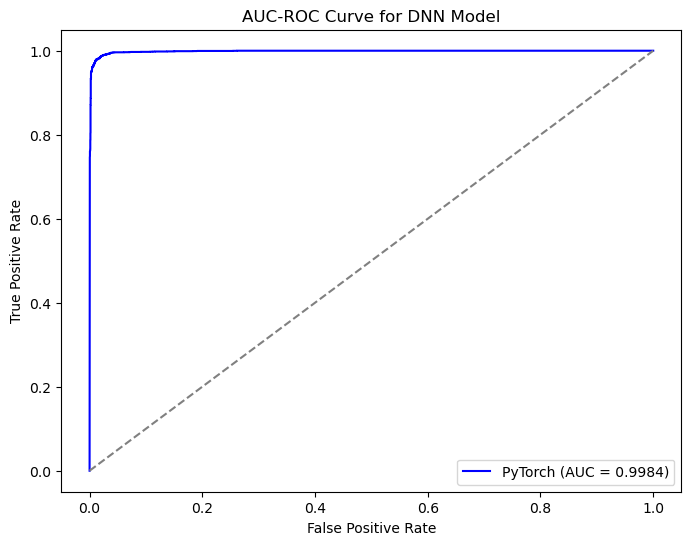

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_proba_list)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"PyTorch (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for DNN Model")
plt.legend()
plt.show()


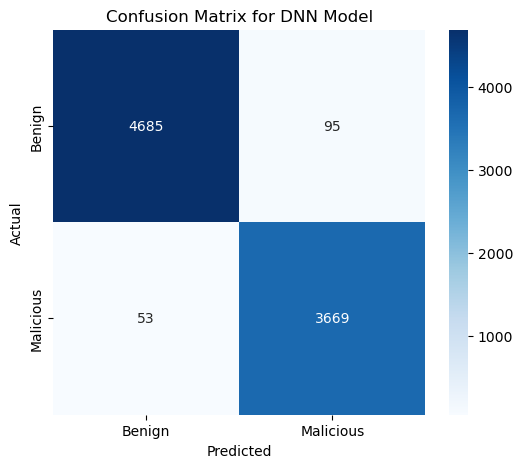

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred_list)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malicious"], yticklabels=["Benign", "Malicious"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for DNN Model")
plt.show()


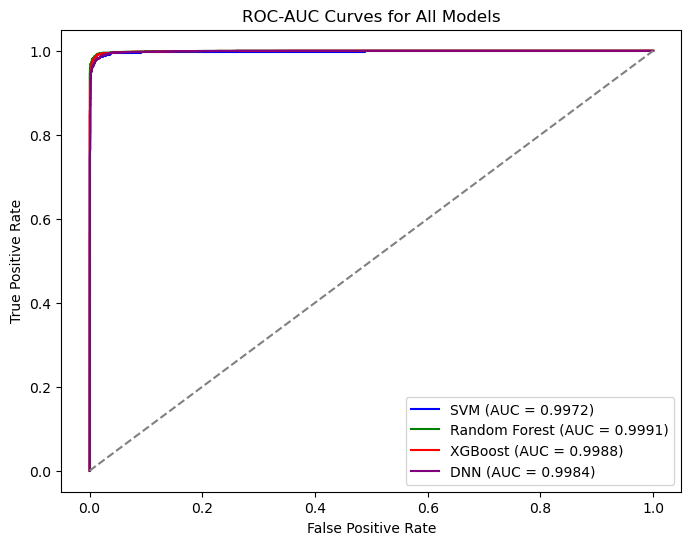

In [32]:
# Store model predictions and probabilities
# SVM- decision scores
svm_probs = best_svm.decision_function(X_test)
# RF- class 1 probabilities
rf_probs = best_rf.predict_proba(X_test)[:, 1]
# XGBoost- class 1 probabilities
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
# PyTorch- precomputed probabilities
pytorch_probs = y_proba_list

model_names = ["SVM", "Random Forest", "XGBoost", "DNN"]
model_probs = [svm_probs, rf_probs, xgb_probs, pytorch_probs]
model_preds = [
    best_svm.predict(X_test),
    best_rf.predict(X_test),
    xgb_model.predict(X_test),   
    y_pred_list
]

# Plot ROC-AUC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'purple']
for i, model in enumerate(model_names):
    fpr, tpr, _ = roc_curve(y_test, model_probs[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f"{model} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves for All Models")
plt.legend()
plt.show()

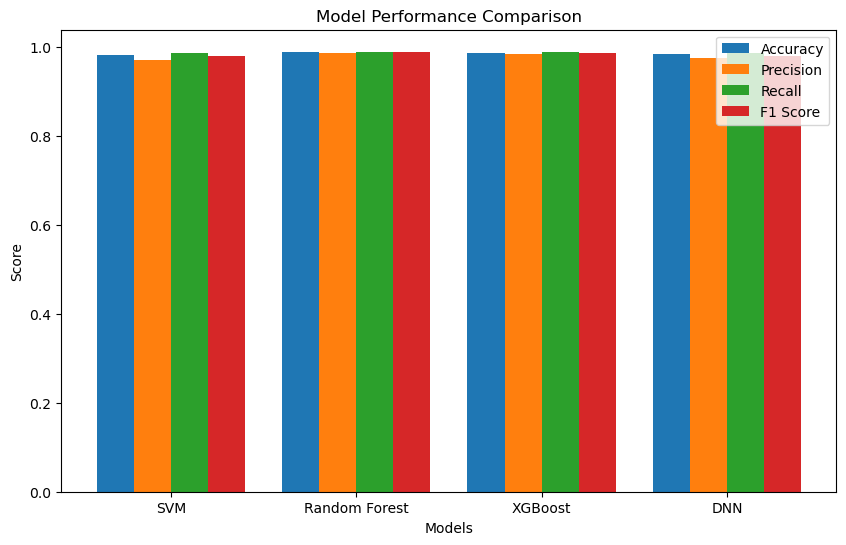

In [33]:
# Store evaluation metrics
metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
# Compute classification metrics
for i, model in enumerate(model_names):
    report = classification_report(y_test, model_preds[i], output_dict=True)
    metrics['Accuracy'].append(report['accuracy'])
    # Class "1" (Maliciou)
    metrics['Precision'].append(report['1']['precision'])
    metrics['Recall'].append(report['1']['recall'])
    metrics['F1 Score'].append(report['1']['f1-score'])

# Bar Plot for Metrics
plt.figure(figsize=(10, 6))
x = np.arange(len(model_names))
width = 0.2

for i, (metric, values) in enumerate(metrics.items()):
    plt.bar(x + (i - 1.5) * width, values, width, label=metric)

plt.xticks(x, model_names)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()

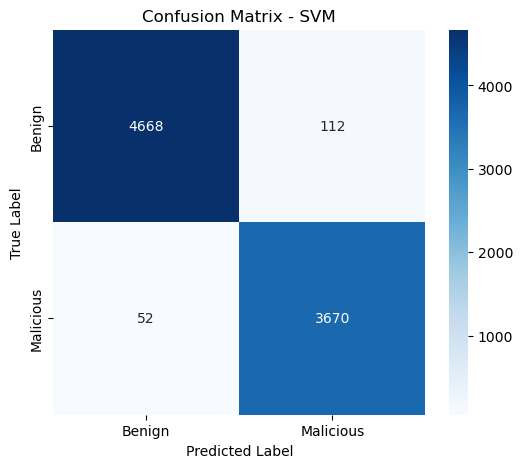

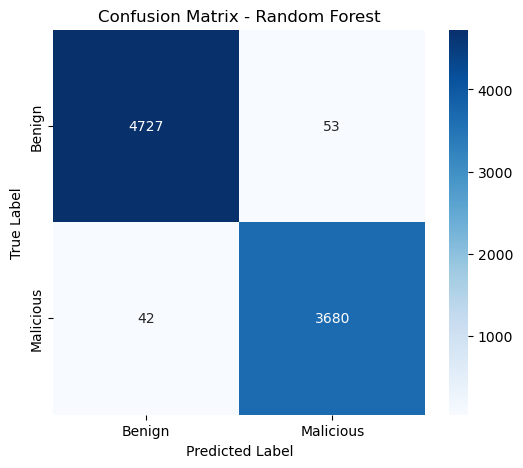

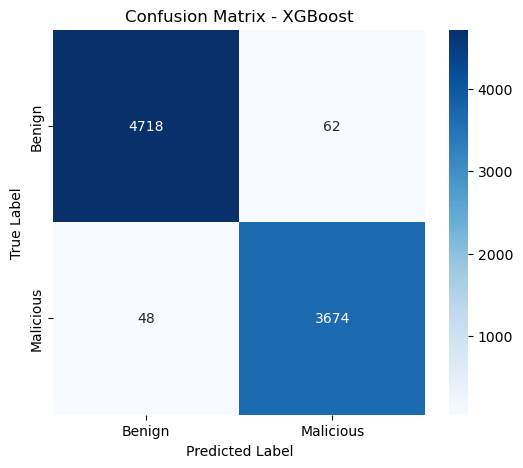

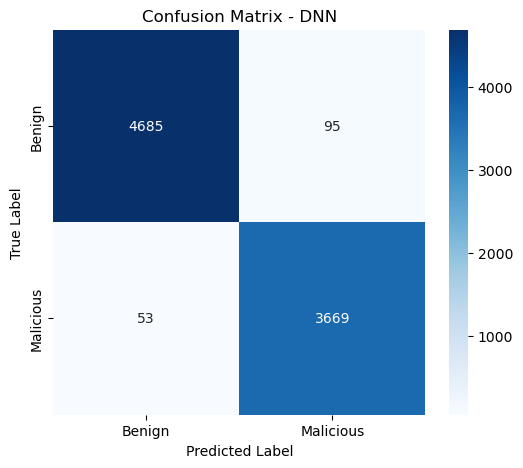

In [34]:
# Confusion Matrix Plotting
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Classes: "Benign" (0) and "Malicious" (1)
class_labels = ["Benign", "Malicious"]
for i, model in enumerate(model_names):
    cm = confusion_matrix(y_test, model_preds[i])
    plot_confusion_matrix(cm, class_labels, f"Confusion Matrix - {model}")